In [1]:
import pickle

data_to_load = {
    "X_train": None,
    "X_valid": None,
    "X_test": None,
    "y_train": None,
    "y_valid": None,
    "y_test": None,
    "y_mean": None, 
    "y_std": None,
    "df_test": None
}
for k in data_to_load.keys():
    with open(k + ".pkl", 'rb') as file:
        data_to_load[k] = pickle.load(file)
X_train, X_valid, X_test = data_to_load["X_train"], data_to_load["X_valid"], data_to_load["X_test"]
y_train, y_valid, y_test = data_to_load["y_train"], data_to_load["y_valid"], data_to_load["y_test"]
y_mean, y_std = data_to_load["y_mean"], data_to_load["y_std"]
df_test = data_to_load["df_test"]

In [2]:
import scutquant.scutquant as q
from scutquant import report, executor

model = q.auto_lgbm(X_train, y_train, X_valid, y_valid)

Training until validation scores don't improve for 30 rounds
[20]	train's l2: 0.884485	valid's l2: 0.899237
[40]	train's l2: 0.882436	valid's l2: 0.898405
[60]	train's l2: 0.880754	valid's l2: 0.897918
[80]	train's l2: 0.879363	valid's l2: 0.897581
[100]	train's l2: 0.878163	valid's l2: 0.897383
[120]	train's l2: 0.877079	valid's l2: 0.897262
[140]	train's l2: 0.876001	valid's l2: 0.897143
[160]	train's l2: 0.874999	valid's l2: 0.897024
[180]	train's l2: 0.873988	valid's l2: 0.896926
[200]	train's l2: 0.872996	valid's l2: 0.896851
[220]	train's l2: 0.871967	valid's l2: 0.896785
[240]	train's l2: 0.870965	valid's l2: 0.896715
[260]	train's l2: 0.869965	valid's l2: 0.896688
[280]	train's l2: 0.8689	valid's l2: 0.896655
[300]	train's l2: 0.867877	valid's l2: 0.896638
[320]	train's l2: 0.866971	valid's l2: 0.896623
[340]	train's l2: 0.865973	valid's l2: 0.89662
Early stopping, best iteration is:
[328]	train's l2: 0.86654	valid's l2: 0.896608


In [3]:
import pandas as pd

pred = model.predict(X_test)
pred = pd.DataFrame(pred, columns=["predict"], index=X_test.index)
pred["predict"] += y_mean
pred["predict"] *= y_std
pred.describe()

,predict
count,281840.000000
mean,-0.000163
std,0.001559
min,-0.017840
25%,-0.000943
50%,-0.000064
75%,0.000731
max,0.011813


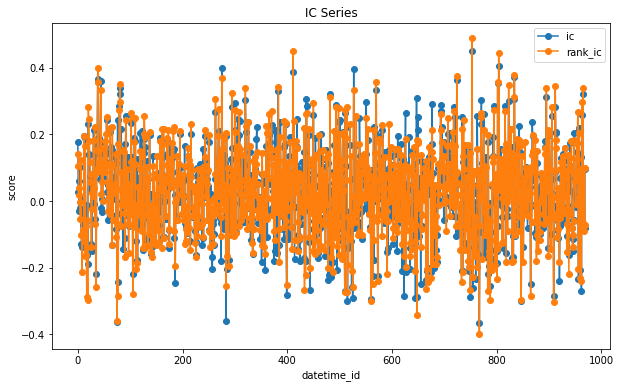

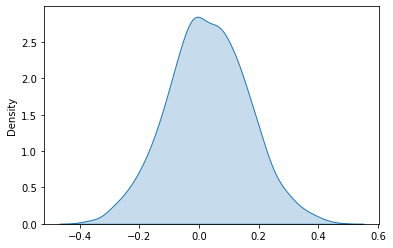

ic= 0.02858981514621951 icir= 0.21263297388562544 rank_ic= 0.029148974928175055 rank_icir= 0.2151853580812174


0.02434190695460737

In [4]:
ic, icir, rank_ic, rank_icir = q.ic_ana(pred["predict"], y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)
# 使用pearson相关系数评判拟合优度
r = q.pearson_corr(pred["predict"].values, y_test)
r

Accuracy of Prediction: 0.5283347430220409


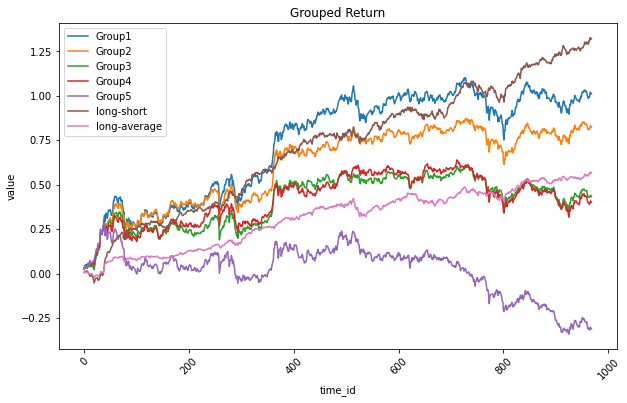

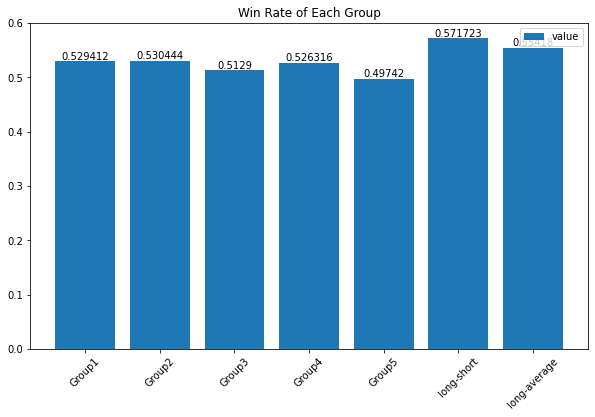

In [5]:
pred = executor.prepare(pred, df_test, price='mean_price', volume='vol')
report.group_return_ana(pred, y_test)

In [6]:
backtest = {
    "generator": {
        "mode": "generate"
    },
    "strategy": {
        "class": "TopKStrategy",  # 做多预测值前20%的股票, 做空后20%的股票. 
        "kwargs": {
            "auto_offset": False,
            "offset_freq": 2, # 应为delta_t + 1, 例如目标值是close_-2 / close_-1 - 1, 则delta_t = 1
            "buy_only": False,  # =True时，只做多不做空(在A股做空有一定的难度)
            "short_volume": 1000,
            "risk_degree": 0.95,  # 将风险度控制在这个数，如果超过了就按比例减持股票直到风险度小于等于它为止
            "unit": None,  # 由于数据已经是以手为单位, 故无需二次处理
            "max_volume": 1  # 手数随可用资金而改变，最大不会超过股票当天成交量的x%(例如T+1时下单，下单手数不会超过T时成交量的x%)
        }
    },
    "account": None,  # 使用默认账户, 即初始资金为1亿, 无底仓
    "trade_params": {
        "cost_buy": 0.0015,  # 佣金加上印花税
        "cost_sell": 0.0005,  
        "min_cost": 5,
    }
}
generator, strategy, account, trade_params = backtest["generator"], backtest["strategy"], backtest["account"], backtest["trade_params"]
exe = executor.Executor(generator, strategy, account, trade_params)
exe.execute(data=pred, verbose=0)

Annualized Return: 0.13895739980773492
Annualized Volatility: 0.39627725794399743
Annualized Return(Benchmark): 0.07899686073853784
Annualized Volatility(Benchmark): 0.3389941216655789 

Cumulative Rate of Return: 0.6492432561244881
Cumulative Rate of Return(Benchmark): 0.33958556303554865
Cumulative Excess Rate of Return: 0.3096576930889394 

Max Drawdown: -0.27882855780299565
Max Drawdown(Benchmark): -0.5462600364770351 

Sharpe Ratio: 2.6945169586772235
Sortino Ratio: 0.682545527912269
Information Ratio: 0.6435331885582329 

Beta: 1.0747350850131
Alpha: 0.0990674604515906
Epsilon: 0.07949553316045686
Profitable Days(%): 0.9246646026831785


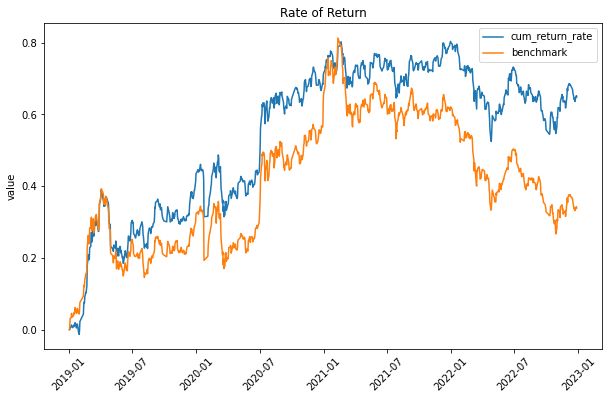

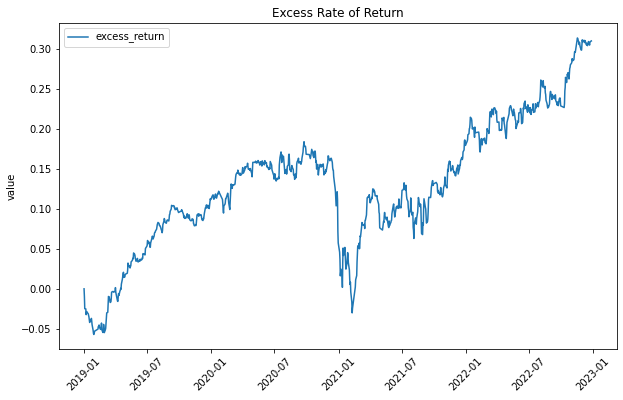

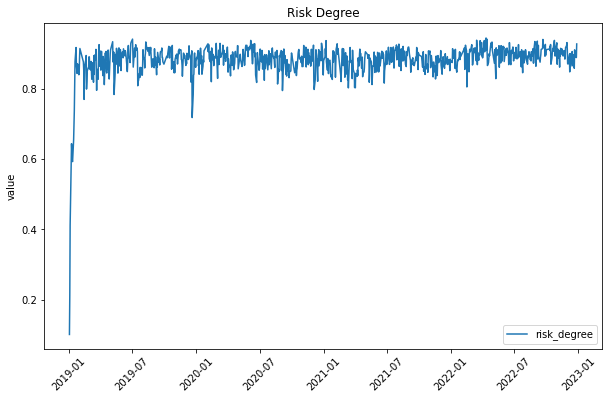

In [7]:
user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, freq=365, time=exe.time)  # 无风险收益率默认为年化3%，可以通过参数rf调节

In [8]:
with open("lgbm/lgbm.pkl", "wb") as file:
    pickle.dump(model, file)
file.close()